Looking at density at various cross sections in a particular model run.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (nc_tools, viz_tools, gsw_calls)
import numpy.ma as ma
from matplotlib import animation, rc
%matplotlib inline

In [2]:
mesh_mask = nc.Dataset('/home/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')
new_domain = mesh_mask.variables['tmask'][0,:,334:898,114:398]  

In [4]:
rc('animation', html='html5')

In [3]:
def calc_rho(Sal, TempC, P):
    """ Calculate rho: Based on SOG code
    """
    
    # Calculate the square root of the salinities
    sqrSal = np.sqrt(Sal)

    # Calculate the density profile at the grid point depths
    # Pure water density at atmospheric pressure
    # (Bigg P.H., (1967) Br. J. Applied Physics 8 pp 521-537)
    R1 = ((((6.536332e-9 * TempC - 1.120083e-6) * TempC + 1.001685e-4)
           * TempC - 9.095290e-3) * TempC + 6.793952e-2) * TempC - 28.263737
    R2 = (((5.3875e-9 * TempC - 8.2467e-7) * TempC + 7.6438e-5)
          * TempC - 4.0899e-3) * TempC + 8.24493e-1
    R3 = (-1.6546e-6 * TempC + 1.0227e-4) * TempC - 5.72466e-3

    # International one-atmosphere equation of state of seawater
    SIG = (4.8314e-4 * Sal + R3 * sqrSal + R2) * Sal + R1

    # Specific volume at atmospheric pressure
    V350P = 1.0 / 1028.1063
    SVA   = -SIG * V350P / (1028.1063 + SIG)

    # Density anomoly at atmospheric pressure
    rho = 28.106331 - SVA / (V350P * (V350P + SVA)) + 1000
    
    return rho

In [114]:
def animatedensity(file, yslice, xlims, ylims, mesh_mask):
    pressure1 = gsw_calls.generic_gsw_caller('gsw_p_from_z.m',
                                        [-np.expand_dims(file.variables['deptht'][:], 1) * np.ones(284),
                                        (np.ones([284,40]) *np.expand_dims(file.variables['nav_lat'][yslice,:][:],1)).T])
    fig,ax = plt.subplots(figsize=(8,8))
    deptht = file.variables['deptht'][:]
    yslicemask = 1 - mesh_mask[:,yslice,:]
    def animate30(i):
        ax.clear()
        density1 = calc_rho(file.variables['vosaline'][i,:,yslice,:],
                                        file.variables['votemper'][i,:,yslice,:],
                                        pressure1)
        masked_density1 = ma.masked_array(density1, mask = yslicemask)
        den = ax.pcolormesh(np.arange(0,284), deptht, masked_density1, 
                      vmin = 1021.8,vmax = 1024.5, cmap = 'bwr' #, colors='black'
            )
        ax.contour(np.arange(0,284), deptht, masked_density1,levels=[1023.3], colors='black')
        ax.set_ylim(ylims)
        ax.set_xlim(xlims)
        ax.set_title('Y = ' + str(yslice) + ', hour = %03d'%(i)) 
        return ax

    interval = 0.25#in seconds
    ani40 = animation.FuncAnimation(fig,animate30,frames=155,interval=interval*1e+3, repeat=False)
    return ani40

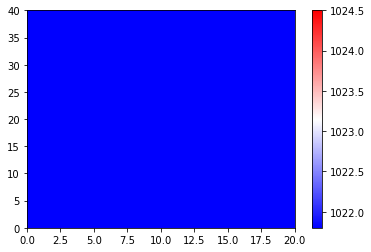

In [108]:
plt.pcolormesh(np.ones((40,20)), 
                      vmin = 1021.8, vmax =1024.5, cmap = 'bwr')
plt.colorbar()

In [6]:
NU0 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/NU0/SalishSea_1h_20170101_20170107_grid_T.nc')

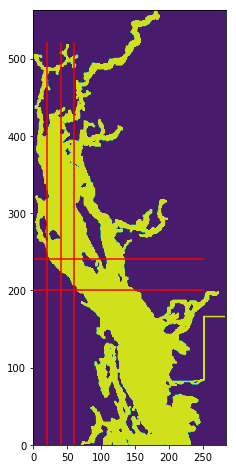

In [96]:
fig, ax = plt.subplots(figsize=(10,8))
plt.contourf(new_domain[0,:,:])
viz_tools.set_aspect(ax)
ax.plot((0,250), (200,200), 'r-')
ax.plot((0,250), (240,240), 'r-')
ax.plot((20,20), (0,520), 'r-')
ax.plot((40,40), (0,520), 'r-')
ax.plot((60,60), (0,520), 'r-')

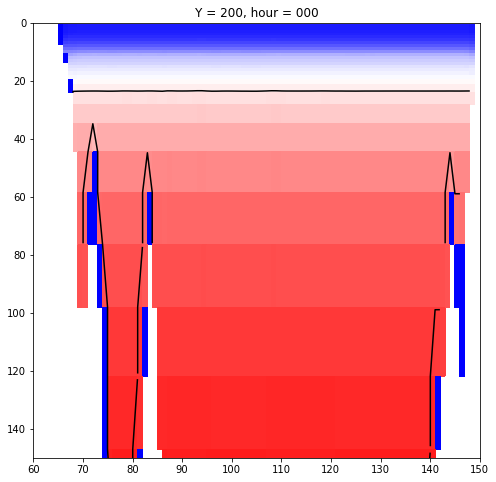

In [115]:
animatedensity(NU0, 200, [60,150], [150,0], new_domain)

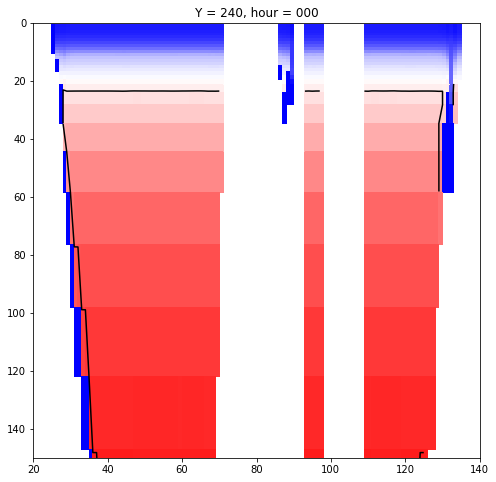

In [116]:
animatedensity(NU0,240,[20,140], [150,0], new_domain)

In [22]:
SS0 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/SS0/SalishSea_1h_20160601_20160607_grid_T.nc')

In [118]:
def animatedensity2(file, xslice, xlims, ylims, mesh_mask):
    pressure1 = gsw_calls.generic_gsw_caller('gsw_p_from_z.m',
                                        [-np.expand_dims(file.variables['deptht'][:], 1) * np.ones(564),
                                        (np.ones([564,40]) *np.expand_dims(file.variables['nav_lat_grid_T'][:, xslice][:],1)).T])
    fig,ax = plt.subplots(figsize=(8,8))
    deptht = file.variables['deptht'][:]
    xslicemask = 1 - mesh_mask[:,:, xslice]
    def animate30(i):
        ax.clear()
        density1 = calc_rho(file.variables['vosaline'][i,:,:, xslice],
                                        file.variables['votemper'][i,:,:, xslice],
                                        pressure1)
        masked_density1 = ma.masked_array(density1, mask = xslicemask)
        den = ax.pcolormesh(np.arange(0,564), deptht, masked_density1, 
                      vmin = 1021.8,vmax = 1024.5, cmap = 'bwr' #, colors='black'
            )
        ax.contour(np.arange(0,564), deptht, masked_density1,levels=[1023.3], colors='black')
        ax.set_ylim(ylims)
        ax.set_xlim(xlims)
        ax.set_title('X = ' + str(xslice) + ', hour = %03d'%(i)) 
        return ax

    interval = 0.25#in seconds
    ani40 = animation.FuncAnimation(fig,animate30,frames=155,interval=interval*1e+3, repeat=False)
    return ani40

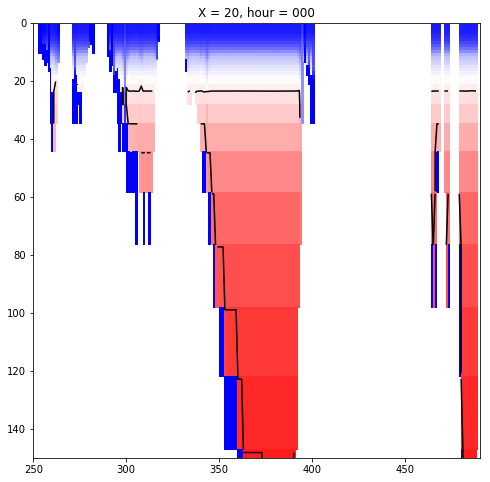

In [119]:
animatedensity2(SS0, 20, (250,490), (150,0), new_domain)

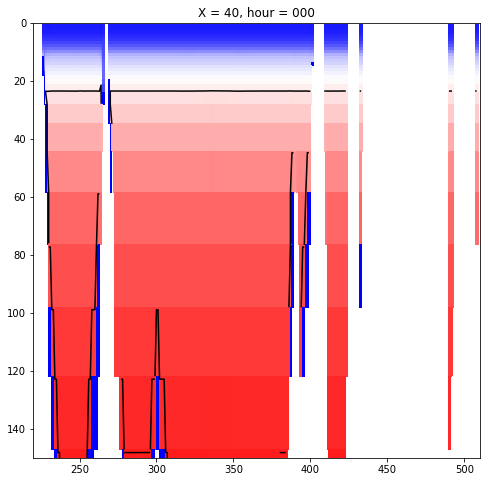

In [120]:
animatedensity2(SS0, 40, (220,510), (150,0), new_domain)

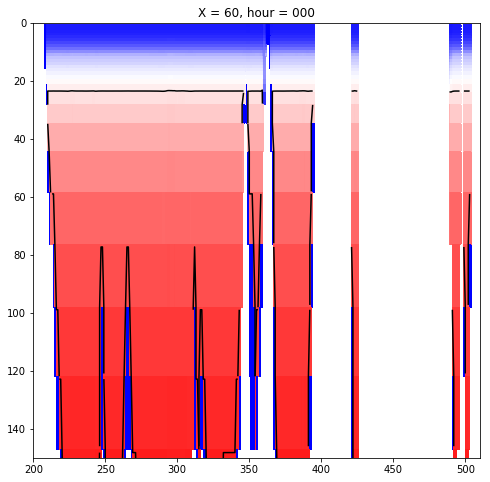

In [121]:
animatedensity2(SS0, 60, (200,510), (150,0), new_domain)